In [1]:
from benchmark_consts import get_problems, get_args_and_problems, print_, PATH_FORM_HYPERPARAMS


import os
import pickle
import traceback
import argparse
import random
import math

import sys
sys.path.append('..')

from lib.algorithms import PathFormulation
from lib.problem import Problem
from lib.graph_utils import compute_in_or_out_flow


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

TOP_DIR = 'path-form-logs'
HEADERS = [
    'problem', 'num_nodes', 'num_edges', 'traffic_seed', 'scale_factor',
    'tm_model', 'num_commodities', 'total_demand', 'algo', 'num_paths',
    'edge_disjoint', 'dist_metric', 'total_flow', 'runtime'
]
PLACEHOLDER = ','.join('{}' for _ in HEADERS)


In [2]:
#Input: a Problem, and a list of number representing the divisions
def split_problem(problem, num_subproblems):
    sub_problems = []
    num_rows = len(problem.traffic_matrix.tm)
    rows_per_problem = math.floor(num_rows/num_subproblems)
    shuffled_indices = list(range(num_rows))
    
    for i in range(num_subproblems):
        
        sub_problems.append(problem.copy())
        for indx, j in enumerate(shuffled_indices):
            
            # zero out all rows except those in the corresponding block of shuffled indices
            # first, cover special case for last block
            if i == num_subproblems-1:
                if indx < i*rows_per_problem:
                    sub_problems[-1].traffic_matrix.tm[j,:] = 0
            
            elif (indx < i*rows_per_problem) or (indx >= (i+1)*rows_per_problem):
                sub_problems[-1].traffic_matrix.tm[j,:] = 0
            
        # split the capacity of each link
        for u,v in sub_problems[-1].G.edges:
            sub_problems[-1].G[u][v]['capacity'] = sub_problems[-1].G[u][v]['capacity']/num_subproblems

    return sub_problems
        
# Sweep topos and traffic matrices for that topo. For each combo, record the
# runtime and total flow for each algorithm
def benchmark_split(problems, num_subproblems_list):
    num_paths, edge_disjoint, dist_metric = PATH_FORM_HYPERPARAMS
    all_results = {}
    all_runtimes = {}
    all_sol_dicts = {}
    with open('path-form.csv', 'a') as results:
        print_(','.join(HEADERS), file=results)
        for problem_name, topo_fname, tm_fname in problems:
            problem = Problem.from_file(topo_fname, tm_fname)
            
            problem_results = [[] for _ in range(len(num_subproblems_list))]
            problem_runtimes = [[] for _ in range(len(num_subproblems_list))]
            problem_sol_dicts = [[] for _ in range(len(num_subproblems_list))]
            for nsp_i, num_subproblems in enumerate(num_subproblems_list):
                
                problem_list = split_problem(problem, num_subproblems)
                sum_obj_val = 0
                for sp_i, sub_problem in enumerate(problem_list):

                    print_(sub_problem.name, tm_fname)
                    traffic_seed = sub_problem.traffic_matrix.seed
                    total_demand = sub_problem.total_demand
                    print_('traffic seed: {}'.format(traffic_seed))
                    print_('traffic scale factor: {}'.format(
                        sub_problem.traffic_matrix.scale_factor))
                    print_('traffic matrix model: {}'.format(
                        sub_problem.traffic_matrix.model))
                    print_('total demand: {}'.format(total_demand))

                    run_dir = os.path.join(
                        TOP_DIR, sub_problem.name,
                        '{}-{}'.format(traffic_seed, sub_problem.traffic_matrix.model))
                    if not os.path.exists(run_dir):
                        os.makedirs(run_dir)

                    try:
                        print_(
                            '\nPath formulation, {} paths, edge disjoint {}, dist metric {}'
                            .format(num_paths, edge_disjoint, dist_metric))
                        with open(
                                os.path.join(
                                    run_dir,
                                    '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}.txt'
                                    .format(sub_problem.name, num_paths, edge_disjoint,
                                            dist_metric)), 'w') as log:
                            pf = PathFormulation.new_max_flow(
                                num_paths,
                                edge_disjoint=edge_disjoint,
                                dist_metric=dist_metric,
                                out=log)

                            pf.solve(sub_problem)
                            pf_sol_dict = pf.extract_sol_as_dict()
                            with open(
                                    os.path.join(
                                        run_dir,
                                        '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}_sol-dict.pkl'
                                        .format(sub_problem.name, num_paths, edge_disjoint,
                                                dist_metric)), 'wb') as w:
                                pickle.dump(pf_sol_dict, w)

                        result_line = PLACEHOLDER.format(
                            sub_problem.name,
                            len(sub_problem.G.nodes),
                            len(sub_problem.G.edges),
                            traffic_seed,
                            sub_problem.traffic_matrix.scale_factor,
                            sub_problem.traffic_matrix.model,
                            len(problem.commodity_list),
                            total_demand,
                            'path_formulation',
                            num_paths,
                            edge_disjoint,
                            dist_metric,
                            pf.obj_val,
                            pf.runtime,
                        )
                        print_(result_line, file=results)
                        problem_results[nsp_i].append(pf.obj_val)
                        problem_runtimes[nsp_i].append(pf.runtime)
                        problem_sol_dicts[nsp_i].append(pf_sol_dict)
                        sum_obj_val += pf.obj_val
                    except Exception:
                        print_(
                            'Path formulation {} paths, edge disjoint {}, dist metric {}, Problem {}, traffic seed {}, traffic model {} failed'
                            .format(num_paths, edge_disjoint, dist_metric,
                                    sub_problem.name, traffic_seed,
                                    sub_problem.traffic_matrix.model))
                        traceback.print_exc(file=sys.stdout)
                print("sum of obj vals: " + str(sum_obj_val))
               
            all_results[(problem_name, topo_fname, tm_fname)] = problem_results
            all_runtimes[(problem_name, topo_fname, tm_fname)] = problem_runtimes
            all_sol_dicts[(problem_name, topo_fname, tm_fname)] = problem_sol_dicts
    return all_results, all_runtimes, all_sol_dicts

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--dry-run',
                        dest='dry_run',
                        action='store_true',
                        default=False)

parser.add_argument('--slices',
                        type=int,
                        choices=range(5),
                        nargs='+',
                        required=True)
args = parser.parse_args("--slices 0".split())

if not os.path.exists(TOP_DIR):
    os.makedirs(TOP_DIR)

#problems = get_problems(args)

if args.dry_run:
    print('Problems to run:')
    for problem in problems:
        print(problem)

p1 = ("uniform 64", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
p2 = ("poisson-inter 128", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/poisson-high-inter/GtsCe.graphml_poisson_2035531455_128.0_1000.0_0.9_8.5e-05_traffic-matrix.pkl")
p3 = ("poisson-intra 128", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/poisson-high-intra/GtsCe.graphml_poisson_1367969278_128.0_200000000.0_0.1_2.25e-06_traffic-matrix.pkl")

num_subproblems = [1,2,4,8]
problems = [p1, p2]
results, runtimes, sol_dicts = benchmark_split(problems, num_subproblems)

GtsCe.graphml ../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl
traffic seed: 1475504323
traffic scale factor: 64.0
traffic matrix model: uniform
total demand: 35469.390625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Academic license - for non-commercial use only
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 22438 rows, 42492 columns and 555575 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-05, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 3937 rows and 1786 columns
Presolve time: 0.19s
Presolved: 18501 rows, 40706 columns, 510542 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.854e+05
 Factor NZ

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5844 rows, 9932 columns and 133898 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 2e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1432 rows and 418 columns
Presolve time: 0.08s
Presolved: 4412 rows, 9514 columns, 119519 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.198e+05
 Factor NZ  : 1.342e+05 (roughly 7 MBytes of memory)
 Factor Ops : 7.398e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.77871494e+05  3.88111307e+03  1.03e+05 1.00e+00  1.20e+02     0s
   1   8.5675

traffic scale factor: 64.0
traffic matrix model: uniform
total demand: 4358.875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 3015 rows, 4463 columns and 63771 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1105 rows and 396 columns
Presolve time: 0.03s
Presolved: 1910 rows, 4067 columns, 54056 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.204e+04
 Factor NZ  : 6.021e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.700e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Prim

   5   1.82520719e+03  2.66185773e+03  1.68e+00 7.09e-05  1.08e-01     0s
   6   1.85219979e+03  2.50820105e+03  1.41e+00 4.25e-05  8.45e-02     0s
   7   1.93628452e+03  2.28529653e+03  6.85e-01 4.44e-16  4.46e-02     0s
   8   1.97951432e+03  2.19862533e+03  4.22e-01 8.88e-16  2.80e-02     0s
   9   2.00784112e+03  2.12605559e+03  2.95e-01 1.11e-15  1.52e-02     0s
  10   2.04006846e+03  2.09655477e+03  1.36e-01 1.78e-15  7.23e-03     0s

Barrier performed 10 iterations in 0.18 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 2647 iterations and 0.18 seconds
Optimal objective  2.069776531e+03
GtsCe.graphml ../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl
traffic seed: 1475504323
traffic scale factor: 64.0
traffic matrix model: uniform
total demand: 4334.009765625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: 

  16   5.51717754e+04  5.62385382e+04  7.86e+00 1.14e-04  2.41e-02     2s
  17   5.52653809e+04  5.61214922e+04  6.13e+00 9.16e-05  1.91e-02     2s
  18   5.53635545e+04  5.60219019e+04  4.38e+00 7.07e-05  1.44e-02     2s
  19   5.54017418e+04  5.59593139e+04  3.74e+00 5.79e-05  1.22e-02     2s
  20   5.54284583e+04  5.59079017e+04  3.30e+00 4.76e-05  1.06e-02     3s
  21   5.54554975e+04  5.58697113e+04  2.86e+00 4.01e-05  9.13e-03     3s
  22   5.55046368e+04  5.58201920e+04  2.09e+00 3.14e-05  6.87e-03     3s
  23   5.55458636e+04  5.57725180e+04  1.46e+00 2.11e-05  4.90e-03     3s
  24   5.55708726e+04  5.57605677e+04  1.09e+00 1.88e-05  3.99e-03     3s
  25   5.56111292e+04  5.57135623e+04  5.38e-01 1.00e-05  2.11e-03     3s
  26   5.56257925e+04  5.56836691e+04  3.48e-01 4.60e-06  1.23e-03     3s
  27   5.56363168e+04  5.56735709e+04  2.12e-01 2.86e-06  7.80e-04     3s
  28   5.56422953e+04  5.56705431e+04  1.37e-01 2.38e-06  5.72e-04     3s
  29   5.56465990e+04  5.56645319e+04 

   0   1.44036917e+06  1.58259116e+04  1.31e+05 1.19e+00  4.56e+02     0s
   1   1.60176433e+05  6.61771609e+04  1.38e+04 8.50e-01  5.34e+01     0s
   2   2.60457079e+04  6.18337165e+04  1.52e+03 1.32e-01  8.84e+00     0s
   3   1.32619326e+04  2.98205238e+04  4.50e+02 1.09e-02  2.61e+00     0s
   4   9.12364709e+03  1.53041237e+04  9.51e+01 1.09e-03  6.58e-01     0s
   5   8.81522242e+03  1.20252170e+04  3.78e+01 3.31e-04  2.93e-01     0s
   6   8.94180760e+03  1.10262512e+04  2.36e+01 1.82e-04  1.83e-01     0s

Barrier performed 6 iterations in 0.29 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 3791 iterations and 0.30 seconds
Optimal objective  9.566357753e+03
GtsCe.graphml ../traffic-matrices/poisson-high-inter/GtsCe.graphml_poisson_2035531455_128.0_1000.0_0.9_8.5e-05_traffic-matrix.pkl
traffic seed: 2035531455
traffic scale factor: 128.0
traffic matrix model: poisson
total demand: 24700.3203125

Path formulation, 4 pat


Barrier performed 2 iterations in 0.10 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 300 iterations and 0.10 seconds
Optimal objective  2.293118720e+03
GtsCe.graphml ../traffic-matrices/poisson-high-inter/GtsCe.graphml_poisson_2035531455_128.0_1000.0_0.9_8.5e-05_traffic-matrix.pkl
traffic seed: 2035531455
traffic scale factor: 128.0
traffic matrix model: poisson
total demand: 12543.3779296875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 3018 rows, 5186 columns and 66381 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


total demand: 13521.283203125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 3020 rows, 5506 columns and 66181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 298 rows and 57 columns
Presolve time: 0.04s
Presolved: 2722 rows, 5449 columns, 64541 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.569e+04
 Factor NZ  : 9.659e+04 (roughly 4 MBytes of memory)
 Factor Ops : 7.292e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl   

sol_dict: 23559.777672007924, actual obj: 55654.95155115834
sol_dict: 22513.841269725366, actual obj: 48625.15384483338
sol_dict: 20174.87611303781, actual obj: 39265.88860297203
sol_dict: 16315.909989268075, actual obj: 26754.108711525798
sol_dict: 55654.95155115834, actual obj: 55654.95155115834
sol_dict: 48625.15384483337, actual obj: 48625.15384483338
sol_dict: 39265.88860297203, actual obj: 39265.88860297203
sol_dict: 26754.108711525798, actual obj: 26754.108711525798


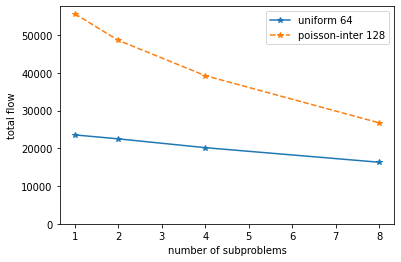

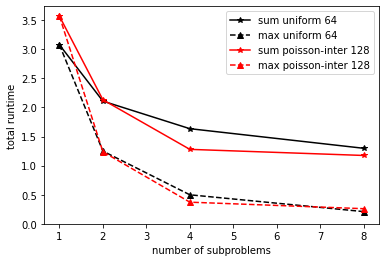

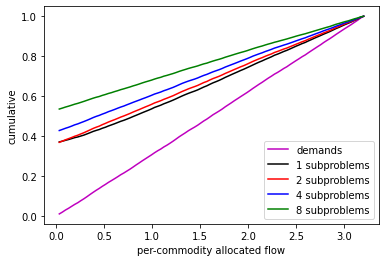

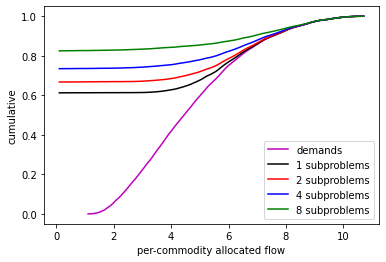

In [4]:
colors = ['k', 'r', 'b', 'g']
linestyles = ['-', '--', ':']

fig, ax = plt.subplots()
for p_i, p in enumerate(problems):
    total_obj_values = []
    for n_i, n in enumerate(num_subproblems):
        sum_val = sum(results[p][n_i])
        total_obj_values.append(sum_val)
    ax.plot(num_subproblems, total_obj_values, marker='*', linestyle=linestyles[p_i], label=p[0])
ax.legend()
plt.xlabel('number of subproblems')
plt.ylabel('total flow')
plt.ylim([0,None])

fig, ax = plt.subplots()
for p_i, p in enumerate(problems):
    total_runtime = []
    max_runtime = []
    for n_i, n in enumerate(num_subproblems):
        sum_val = sum(runtimes[p][n_i])
        max_time = max(runtimes[p][n_i])
        total_runtime.append(sum_val)
        max_runtime.append(max_time)
    ax.plot(num_subproblems, total_runtime, marker='*', linestyle=linestyles[0], c=colors[p_i], label='sum ' + p[0])
    ax.plot(num_subproblems, max_runtime, marker='^', linestyle=linestyles[1], c=colors[p_i], label='max ' + p[0])
ax.legend()
plt.xlabel('number of subproblems')
plt.ylabel('total runtime')
plt.ylim([0,None])

for p_spec in problems:
    problem = Problem.from_file(p_spec[1], p_spec[2])
    com_list = problem.commodity_list
    
    fig,ax = plt.subplots()
    
    # plot the demand distribution
    demands = [ com_list[i][1][2] for i in range(len(com_list)) ]
    num_bins = 100
    counts, bin_edges = np.histogram(demands, bins=num_bins)
    cdf = np.cumsum(counts)
    ax.plot(bin_edges[1:], cdf/cdf[-1], c='m', label="demands")

    for n_i, n in enumerate(num_subproblems):
        flow_counts = []
        for j in range(n):
            sol_dict = sol_dicts[p_spec][n_i][j]
            
            
            total_flow = 0
            for commod_key, flow_list in sol_dict.items():
                flow = compute_in_or_out_flow(flow_list, 0, {commod_key[-1][0]})
                total_flow += flow
                flow_counts.append(flow)
            # get amount of flow assigned to each commodity (ASSUMING SINGLE PATH)
            #flow_counts += [ sol_dict[sdf][0][1] for sdf in sol_dict if len(sol_dict[sdf]) > 0 ]
            
        num_bins = 100
        print("sol_dict: " + str(sum(flow_counts)) + ", actual obj: " + str(sum(results[p][n_i])))
        counts, bin_edges = np.histogram(flow_counts, bins=num_bins)
        cdf = np.cumsum(counts)
        ax.plot(bin_edges[1:], cdf/cdf[-1], c=colors[n_i], label=str(n)+" subproblems")

    plt.xlabel('per-commodity allocated flow')
    plt.ylabel('cumulative')
    plt.legend()
            
            
             

    
#print(results)
    

In [5]:
problem = Problem.from_file("../topologies/topology-zoo/GtsCe.graphml", 
                            "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
problem.G
#print(problem.G.edges.data())
print(problem.commodity_list[0])
#problem2 = problem.copy()
#print(dir(problem))
"""
problem2.traffic_matrix.tm
new_tm = problem2.traffic_matrix.tm[0:10,:]

num_rows = len(problem2.traffic_matrix.tm)

shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)

num_first_problem = math.floor(num_rows/2)

for i in shuffled_indices[1:num_first_problem]:
    problem2.traffic_matrix.tm[i,:] = 0

#print(problem2.traffic_matrix.tm[1:5,:])

for u,v in problem.G.edges:
    problem.G[u][v]['capacity'] = problem.G[u][v]['capacity']/2
    problem2.G[u][v]['capacity'] = problem2.G[u][v]['capacity']/2
"""

(0, (0, 1, 0.7263322))


"\nproblem2.traffic_matrix.tm\nnew_tm = problem2.traffic_matrix.tm[0:10,:]\n\nnum_rows = len(problem2.traffic_matrix.tm)\n\nshuffled_indices = list(range(num_rows))\nrandom.shuffle(shuffled_indices)\n\nnum_first_problem = math.floor(num_rows/2)\n\nfor i in shuffled_indices[1:num_first_problem]:\n    problem2.traffic_matrix.tm[i,:] = 0\n\n#print(problem2.traffic_matrix.tm[1:5,:])\n\nfor u,v in problem.G.edges:\n    problem.G[u][v]['capacity'] = problem.G[u][v]['capacity']/2\n    problem2.G[u][v]['capacity'] = problem2.G[u][v]['capacity']/2\n"

In [12]:
num = 0
for key, value in sol_dict.items():
    print(str(key) + " " + str(sol_dict[key]))
    num += 1
    if (num == 50):
        break

(0, (126, 0, 3.4816)) []
(1, (126, 1, 4.23232)) []
(2, (126, 2, 7.13728)) [((126, 127), 7.137279987335205), ((127, 49), 7.137279987335205), ((49, 128), 7.137279987335205), ((128, 2), 7.137279987335205)]
(3, (126, 3, 6.53888)) [((126, 127), 6.538879871368408), ((127, 49), 6.538879871368408), ((49, 128), 6.538879871368408), ((128, 2), 6.538879871368408), ((2, 3), 6.538879871368408)]
(4, (126, 4, 3.27488)) []
(5, (126, 5, 3.264)) []
(6, (126, 6, 2.60032)) [((126, 64), 2.6003201007843018), ((64, 40), 2.6003201007843018), ((40, 66), 2.6003201007843018), ((66, 102), 2.6003201007843018), ((102, 101), 2.6003201007843018), ((101, 41), 2.6003201007843018), ((41, 98), 2.6003201007843018), ((98, 11), 2.6003201007843018), ((11, 95), 2.6003201007843018), ((95, 16), 2.6003201007843018), ((16, 4), 2.6003201007843018), ((4, 5), 2.6003201007843018), ((5, 6), 2.6003201007843018)]
(7, (126, 7, 2.73088)) []
(8, (126, 8, 2.9376)) []
(9, (126, 9, 3.61216)) [((126, 64), 3.6121599674224854), ((64, 40), 3.61215